# Text Classification - OneClass Classificaiton

The one-class algorithms are based on recognition since their aim is to recognize data from a particular class, and reject data from all other classes. This is accomplished by creating a boundary that encompasses all the data belonging to the target class within itself, so when a new sample arrives the algorithm only has to check whether it lies within the boundary or outside and accordingly classify the sample as belonging to the target class or the outlier.

Things we are going to discuss:

1. Data Preparation 
2. Cleaning and Tokenization
3. Feature Extraction
4. Train One-class classificaiton model
5. Predict one-class on test data

In [3]:
# Load packages
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.svm import OneClassSVM
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 
from nltk.corpus import stopwords
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem.porter import PorterStemmer
import string
import spacy
import keras
from keras import layers
from spacy.lang.en import English
from keras.models import Model , load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint , TensorBoard
from keras import regularizers
import pickle
parser = English()

In [4]:
# load dataset
bbc_df = pd.read_csv('/content/bbc-text.csv')

In [5]:
bbc_df.head(10)

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
5,politics,howard hits back at mongrel jibe michael howar...
6,politics,blair prepares to name poll date tony blair is...
7,sport,henman hopes ended in dubai third seed tim hen...
8,sport,wilkinson fit to face edinburgh england captai...
9,entertainment,last star wars not for children the sixth an...


In [6]:
bbc_df.shape

(2225, 2)

In [7]:
bbc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [8]:
bbc_df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [9]:
bbc_df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


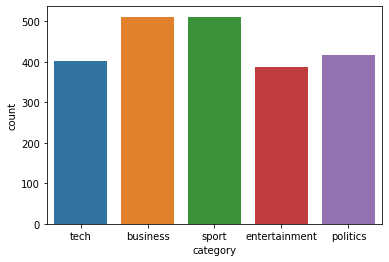

In [10]:
sns.countplot(bbc_df['category'])

## Data preparation

Let's take "sport" category as our traning class for one-class classification

so let's replace the category labels

Since "sport" is our traning class let's replace "sport" with "1" and replace "business, politics, tech and entertainment" with "-1"

becuase one-class classification model prediction will be 1 or -1

here "1" is target class and "-1" is the outlier

In [11]:
# change category labels
bbc_df['category'] = bbc_df['category'].map({'sport':1,'business':-1,'politics':-1,'tech':-1,'entertainment':-1})

In [12]:
# create a new dataset with only sport category data
sports_df = bbc_df[bbc_df['category'] == 1]

In [13]:
sports_df.shape

(511, 2)

In [14]:
sports_df.head()

,category,text
2,1,tigers wary of farrell gamble leicester say ...
3,1,yeading face newcastle in fa cup premiership s...
7,1,henman hopes ended in dubai third seed tim hen...
8,1,wilkinson fit to face edinburgh england captai...
14,1,moya emotional after davis cup win carlos moya...


In [15]:
# create train and test data
train_text = sports_df['text'].tolist()
train_labels = sports_df['category'].tolist()

test_text = bbc_df['text'].tolist()
test_labels = bbc_df['category'].tolist()

## Convert text data into embaddings

In [16]:
!pip install transformers
!pip install sentence-transformers
from transformers import MPNetModel, MPNetConfig
configuration = MPNetConfig()

# Initializing a model from the mpnet-base style configuration
model = MPNetModel(configuration)

# Accessing the model configuration
configuration = model.config
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take average of all tokens
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output.last_hidden_state #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


#Encode text
def encode(texts):
    # Tokenize sentences
    encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors='pt')

    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input, return_dict=True)

    # Perform pooling
    embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

    # Normalize embeddings
    embeddings = F.normalize(embeddings, p=2, dim=1)
    
    return embeddings


# Sentences we want sentence embeddings for
query = "How many people live in London?"
docs = ["Around 9 Million people live in London", "London is known for its financial district"]

# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/multi-qa-mpnet-base-cos-v1")
model = AutoModel.from_pretrained("sentence-transformers/multi-qa-mpnet-base-cos-v1")

#Encode query and docs
query_emb = encode(query)
doc_emb = encode(docs)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
embadding_data=[]
for i in range(0,len(train_text)):
  query_emb = encode(train_text[i])
  embadding_data.append(query_emb.detach().numpy())


In [ ]:
embadding_data_test=[]
for i in range(0,len(test_text)):
  query_emb = encode(test_text[i])
  embadding_data_test.append(query_emb.detach().numpy())

In [ ]:
t=np.array(embadding_data_test)
t=t.reshape(-1,768)
t = pd.DataFrame(t)
t.to_csv("test_data_for_cs725.csv")

In [ ]:
ed=np.array(embadding_data)
ed=ed.reshape(-1,768)
df = pd.DataFrame(ed)
df.to_csv("train_data_for_cs725.csv")

In [18]:
train_emb=pd.read_csv('/content/train_data_for_cs725 (3).csv')
test_emb=pd.read_csv('/content/test_data_for_cs725.csv')
test_emb.drop('Unnamed: 0',inplace=True,axis=1)
train_emb.drop('Unnamed: 0',inplace=True,axis=1)
# print(train_emb.columns)
train_emb=np.array(train_emb)
test_emb=np.array(test_emb)


In [19]:
len(train_emb[0])

768

In [20]:
from sklearn.decomposition import PCA
pca1 = PCA(n_components=400)
pca1.fit(train_emb)
pca2 = PCA(n_components=400)
pca2.fit(test_emb)

PCA(n_components=400)

In [21]:
train_emb_t = pca1.fit_transform(train_emb)
test_emb_t = pca2.fit_transform(test_emb)
# train_emb_t = (train_emb)
# test_emb_t = (test_emb)

In [22]:
len(test_emb)

2225

## One-class SVM

One-class SVM is an unsupervised algorithm that learns a decision function for novelty detection: classifying new data as similar or different to the training set.

In [23]:
# OneClassSVM algorithm
clf = OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)


In [24]:
# fit OneClassSVM model 
clf.fit(train_emb_t, train_labels)

OneClassSVM(gamma=0.1, nu=0.1)

In [25]:
train_labels[0:10]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [26]:
# validate OneClassSVM model with train set
preds_train = clf.predict(train_emb_t)
# print(preds_train)
print("accuracy:", accuracy_score(train_labels, preds_train))

accuracy: 0.8923679060665362


In [27]:
 # validate OneClassSVM model with test set
preds_test = clf.predict(test_emb_t)
preds_test

array([-1, -1, -1, ..., -1, -1,  1])

In [28]:
pickle.dump(clf, open('model_svm.pkl', 'wb'))

In [29]:
len(preds_test)

2225

In [30]:
len(train_labels)

511

In [31]:
results = confusion_matrix(test_labels, preds_test) 
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(test_labels, preds_test)) 
print('Report : ')
print(classification_report(test_labels, preds_test)) 

Confusion Matrix :
[[1536  178]
 [ 385  126]]
Accuracy Score : 0.7469662921348315
Report : 
              precision    recall  f1-score   support

          -1       0.80      0.90      0.85      1714
           1       0.41      0.25      0.31       511

    accuracy                           0.75      2225
   macro avg       0.61      0.57      0.58      2225
weighted avg       0.71      0.75      0.72      2225



In [32]:
from sklearn.ensemble import IsolationForest
Isfo = IsolationForest(random_state=6).fit(train_emb_t, train_labels)

In [33]:
pred=Isfo.predict(test_emb_t)

In [34]:
pickle.dump(Isfo, open('model_Isfo.pkl', 'wb'))


In [35]:
results = confusion_matrix(test_labels, pred) 
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(test_labels, pred)) 
print('Report : ')
print(classification_report(test_labels, pred)) 

Confusion Matrix :
[[1218  496]
 [ 275  236]]
Accuracy Score : 0.6534831460674158
Report : 
              precision    recall  f1-score   support

          -1       0.82      0.71      0.76      1714
           1       0.32      0.46      0.38       511

    accuracy                           0.65      2225
   macro avg       0.57      0.59      0.57      2225
weighted avg       0.70      0.65      0.67      2225



# Auto Encoder

In [36]:
x_train = pd.DataFrame(train_emb_t[0:2000])
x_test = pd.DataFrame(train_emb_t[2000:len(train_emb_t)])

In [37]:
x_train.shape

(511, 400)

In [38]:
from keras.models import load_model
# model = load_model('/content/model.h5')

In [39]:
input = keras.Input(shape=(400,))
encoded = layers.Dense(128, activation='tanh')(input)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(400, activation='tanh')(decoded)

In [40]:
autoencoder = keras.Model(input, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=32,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/100
16/16 [==============================] - 2s 18ms/step - loss: 0.0026
Epoch 2/100
16/16 [==============================] - 0s 13ms/step - loss: 7.5502e-04
Epoch 3/100
16/16 [==============================] - 0s 14ms/step - loss: 2.6279e-04
Epoch 4/100
16/16 [==============================] - 0s 10ms/step - loss: -7.5469e-04
Epoch 5/100
16/16 [==============================] - 0s 14ms/step - loss: -0.0018
Epoch 6/100
16/16 [==============================] - 0s 18ms/step - loss: -0.0023
Epoch 7/100
16/16 [==============================] - 0s 11ms/step - loss: -0.0016
Epoch 8/100
16/16 [==============================] - 0s 18ms/step - loss: -0.0017
Epoch 9/100
16/16 [==============================] - 0s 11ms/step - loss: -0.0028
Epoch 10/100
16/16 [==============================] - 0s 12ms/step - loss: -0.0022
Epoch 11/100
16/16 [==============================] - 0s 13ms/step - loss: -0.0025
Epoch 12/100
16/16 [==============================] - 0s 15ms/step - loss: -0.0030
Epoc

In [41]:
pickle.dump(autoencoder, open('model_autoencoder.pkl', 'wb'))


In [42]:
import math
def mean_error(model,data):
  res1=list()
  for i in range(len(data)):
    d=np.array(data[i:i+1])
    d=d.reshape(-1,400)
    res=model.predict(d)
    d=d.reshape(400)
    # print(res)
    # print(d)
    res=res.reshape(400)
    # print(res)
    error=0
    for i in range(len(d)):
      error+=(res[i]-d[i])**2
    # print(error)
    res1.append(error)
  return res1

In [43]:
ans=mean_error(autoencoder,train_emb_t[0:10])

1/1 [==============================] - 0s 30ms/step


In [44]:
ans


[3.0232176745630124,
 3.5085966026456004,
 5.909614617567004,
 3.8569119765497795,
 9.332540896449787,
 3.667411564875297,
 3.161065371830051,
 2.9615337065832703,
 7.874046162362503,
 6.641912358930162]

In [69]:
test_labels[0:10]

[-1, -1, 1, 1, -1, -1, -1, 1, 1, -1]

In [ ]:
prediction=[]
ans1=mean_error(autoencoder,test_emb_t)
  

In [81]:
ans1

[7.271329242796784,
 5.1768258411915875,
 9.142538794407258,
 7.838957237966521,
 11.192545048259332,
 4.194046816531928,
 4.787606163660903,
 5.148826855451235,
 15.44688451588662,
 6.209833392713987,
 7.351409363507531,
 4.682742754371749,
 7.449280755277655,
 5.149138262900575,
 8.202418111533644,
 4.573850931129752,
 3.947722506698123,
 10.466111399399841,
 4.835339631373517,
 6.46434397939866]

In [82]:
test_labels[0:20]

[-1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1]

In [47]:
threshold=7.271329242796784

In [48]:
def prediction_using_auto_encoder(values,threshold):
  ans=[]
  for i in values:
    if i>threshold:
      ans.append(1)
    else:
      ans.append(-1)
  return ans
  

In [91]:
predictions=prediction_using_auto_encoder(ans1,threshold)

In [145]:
results = confusion_matrix(test_labels, predictions) 
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(test_labels, predictions)) 
print('Report : ')
print(classification_report(test_labels, predictions)) 

Confusion Matrix :
[[1507  207]
 [ 165  346]]
Accuracy Score : 0.832808988764045
Report : 
              precision    recall  f1-score   support

          -1       0.90      0.88      0.89      1714
           1       0.63      0.68      0.65       511

    accuracy                           0.83      2225
   macro avg       0.76      0.78      0.77      2225
weighted avg       0.84      0.83      0.84      2225



In [45]:
def final_prediction(model1,model2,model3,threshold,data):
  pred1=model1.predict(data)
  pred2=model2.predict(data)
  values_from_auto_encoder=mean_error(model3,data)
  pred3=prediction_using_auto_encoder(values_from_auto_encoder,threshold)
  final_pred=[]
  for i in range(len(pred1)):
    cnt1=0
    if(pred1[i]==1):
      cnt1+=1
    if(pred2[i]==1):
      cnt1+=1
    if(pred3[i]==1):
      cnt1+=1
    if(cnt1>=2):
      final_pred.append(1)
    else:
      final_pred.append(-1)
  return final_pred


In [52]:
a=final_prediction(clf,Isfo,autoencoder,threshold,test_emb_t)

1/1 [==============================] - 0s 18ms/step


In [53]:
final_pred=a

In [54]:
results = confusion_matrix(test_labels, final_pred) 
print('Confusion Matrix :')
print(results) 
print('Accuracy Score :',accuracy_score(test_labels, final_pred)) 
print('Report : ')
print(classification_report(test_labels, final_pred)) 

Confusion Matrix :
[[1589  125]
 [ 399  112]]
Accuracy Score : 0.7644943820224719
Report : 
              precision    recall  f1-score   support

          -1       0.80      0.93      0.86      1714
           1       0.47      0.22      0.30       511

    accuracy                           0.76      2225
   macro avg       0.64      0.57      0.58      2225
weighted avg       0.72      0.76      0.73      2225

